In [1]:
library(Seurat)
library(tidyverse)
library(doParallel)
library(patchwork)

library(ggplot2)
library(forcats) # 和 ggplot 一起给数据排序
library(psych)
library(ggrepel)
library(viridis)
library(ggpubr)
library(ggrepel)

library("GSEABase")
library(AUCell)
library(Matrix) 
source("/share/home/qlab/projects/qlab_yrs/scTools.R")
source("/share/home/qlab/projects/qlab_yrs/scPlot.R")
library(ComplexHeatmap)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.1.2”
Loading required package: parallel


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Loading required package: viridisLite

Loading required p

In [2]:
library(msigdbr)
library(fgsea)
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
## 预定义基因集：KEGG+rectome
mdb_c2 <- msigdbr(species = "Homo sapiens", category = "C2")
mdb_kegg = mdb_c2 [grep("^KEGG",mdb_c2 $gs_name),]
mdb_rec = mdb_c2 [grep("^REACTOME",mdb_c2 $gs_name),]
fgsea_kegg_sets <- mdb_kegg %>% split(x = .$gene_symbol, f = .$gs_name)
fgsea_rec_sets <- mdb_rec %>% split(x = .$gene_symbol, f = .$gs_name)
library("hypeR")
# gc()
#draw network
options(browser = "xdg-open")
biosets  <- list()
biosets[["BIOCARTA"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:BIOCARTA")
biosets[["KEGG"]]     <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:KEGG")
biosets[["REACTOME"]] <- msigdb_gsets(species="Homo sapiens", category="C2", subcategory="CP:REACTOME")
biosets[["GO"]] <- msigdb_gsets(species="Homo sapiens", category="C5", subcategory="BP")

Warning message:
“package ‘hypeR’ was built under R version 4.3.0”


In [149]:
# # # --- filter dbt and low_quality cells and ReUmap
# immune <- readRDS('unfilter_B_lung.rds')
# immune@meta.data$b_CellType <- as.character(immune@meta.data$b_CellType)
# meta <- immune@meta.data
# meta$b_CellType[which(meta$b_CellType %in% c('IgM_mature', 'IgA_mature', 'IgG_mature'))] <- 'Plasma_mature'
# meta$b_CellType[which(meta$b_CellType %in% c('IgA_immature'))] <- 'Plasma_immature'
# immune@meta.data <- meta
# immune <- immune %>% subset(b_CellType %in% c('Memory_IgM+_GC', 'Memory_IgM-_GC', 'Mature_naive', 'Plasma_mature', 'Plasma_immature'))

# # --- Reumap
# DefaultAssay(immune) <- 'integrated'
# var.features <- VariableFeatures(immune)
# DefaultAssay(immune) <- "integrated"
# immune <- ScaleData(immune, verbose = FALSE)
# immune <- RunPCA(immune, npcs = 10, verbose = FALSE, features = var.features)
#     # ！使用过滤后的 feature 数据跑 PCA
# immune <- RunUMAP(immune, reduction = "pca", dims = 1:10)
# immune <- FindNeighbors(immune, reduction = "pca", dims = 1:10)
# immune <-  FindClusters(immune, resolution = c(0.1,0.2, 0.4, 0.8,1.2,1.6,2,3))

# # --- Added BCR data
# bcr.immune <- readRDS('All_B_bcr.rds')
# immune@meta.data <- left_join(
#                         immune@meta.data %>% rownames_to_column(var = 'barcode'),
#                         bcr.immune@meta.data %>% dplyr::filter(Site == 'LUNG') %>% 
#                             .[,c('raw_clonotype_id', 'new_ct', 'bcr_pbmc_up_low', 'igh', 'igh_pbmc_up_low', 'igl', 'igl_pbmc_up_low', 'igk', 'igk_pbmc_up_low')] %>% 
#                             rownames_to_column(var = 'barcode'),
#                         by = 'barcode') %>% column_to_rownames(var = 'barcode')

# saveRDS(immune, 'B_lung.rds')

In [4]:
# # --- rename
# immune <- readRDS('./B_lung1.rds')
# meta <- immune@meta.data
# meta$b_CellType[which(meta$b_CellType == 'Mature_naive')] <- 'Bmn_IGHD' # mature naive
# meta$b_CellType[which(meta$b_CellType == 'Memory_IgM+_GC')] <- 'Bm_IGHM+' # memory
# meta$b_CellType[which(meta$b_CellType == 'Memory_IgM-_GC')] <- 'Bm_IGHM-' # memory
# meta$b_CellType[which(meta$b_CellType == 'Plasma_immature')] <- 'Plasma_CCL2' # immature
# meta$b_CellType[which(meta$b_CellType == 'Plasma_mature')] <- 'Plasma_PRDM1' # mature
# unique(meta$b_CellType)
# immune@meta.data <- meta
# saveRDS(immune, './B_lung.rds')

# # --- Add BCR data
# bcr.code.reorder <- readRDS('/share/home/qlab/projects/qlab_yrs/project_ssc/matrix/BCR/cell_bcr_new.rds')
# immune@meta.data <- immune@meta.data %>% rownames_to_column(var = 'barcode') %>% 
#                         .[,c('barcode', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'SamNum', 'SampleID', 'Group', 'Site', 'Gender', 'Age', 'Cohort', 'percent.mt', 'S.Score', 'G2M.Score', 
#                              'Phase', 'IFN.Score1', 'integrated_snn_res.0.1', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'integrated_snn_res.0.8', 'integrated_snn_res.1.2', 
#                              'integrated_snn_res.1.6', 'integrated_snn_res.2', 'integrated_snn_res.3', 'seurat_clusters', 'pANN', 'DF.classifications', 'Stress.Score1', 'DF2', 
#                              'DF_hi.lo', 'b_CellType', 'igh', 'igl', 'igk')] %>% 
#                         left_join(bcr.code.reorder %>% dplyr::rename('BCR_code' = code), by = c('barcode' = 'cell')) %>%
#                         column_to_rownames(var = 'barcode')
# saveRDS(immune, './B_lung.rds')

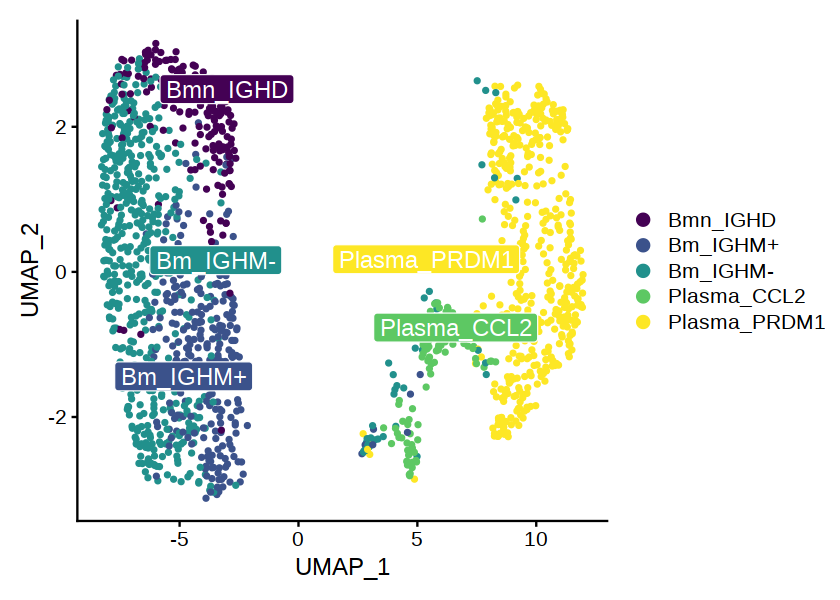

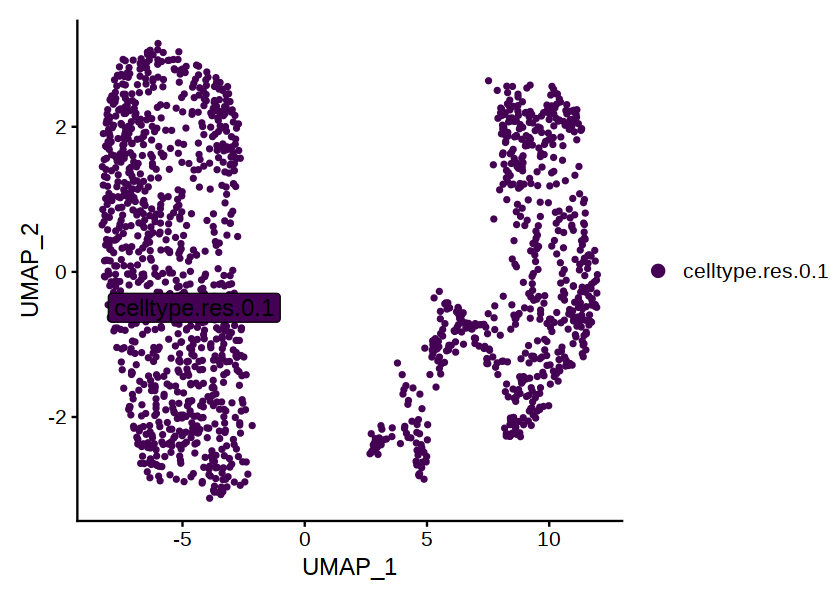

In [3]:
immune <- readRDS('./B_lung.rds')
options(repr.plot.height = 5, repr.plot.width = 7)
ct.order <- c('Bmn_IGHD', 'Bm_IGHM+', 'Bm_IGHM-', 'Plasma_CCL2', 'Plasma_PRDM1')
immune@meta.data$b_CellType <- factor(immune@meta.data$b_CellType, levels = ct.order)
# pdf('./figures/B_UMAP.pdf', width = 7, height = 5)
Idents(immune) <- 'b_CellType'
DimPlot(immune, reduction = "umap", label=TRUE, label.size=5,  cols = viridis(5, option = "D"), 
        label.color = "white", label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) 
# dev.off()

Idents(immune) <- 'celltype.res.0.1'
DimPlot(immune, reduction = "umap", label=TRUE, label.size=5,  cols = viridis(6, option = "D"), 
        label.color = "black", label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) 

In [3]:
DefaultAssay(immune) <- "RNA"
Idents(immune) <- "b_CellType"
markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers, file="SubCellType_Top_Genes.csv")

Calculating cluster Bmn_IGHD

Calculating cluster Bm_IGHM+

Calculating cluster Bm_IGHM-

Calculating cluster Plasma_CCL2

Calculating cluster Plasma_PRDM1



In [15]:
Idents(immune) <- 'b_CellType'
immune@meta.data$b_CellType <- factor(immune@meta.data$b_CellType, levels = ct.order)
markers <- FindAllMarkers(immune, assay = 'RNA', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers, 'B_TopGenes.csv')

Calculating cluster Bmn_IGHD

Calculating cluster Bm_IGHM+

Calculating cluster Bm_IGHM-

Calculating cluster Plasma_CCL2

Calculating cluster Plasma_PRDM1



png 
  2

png 
  2

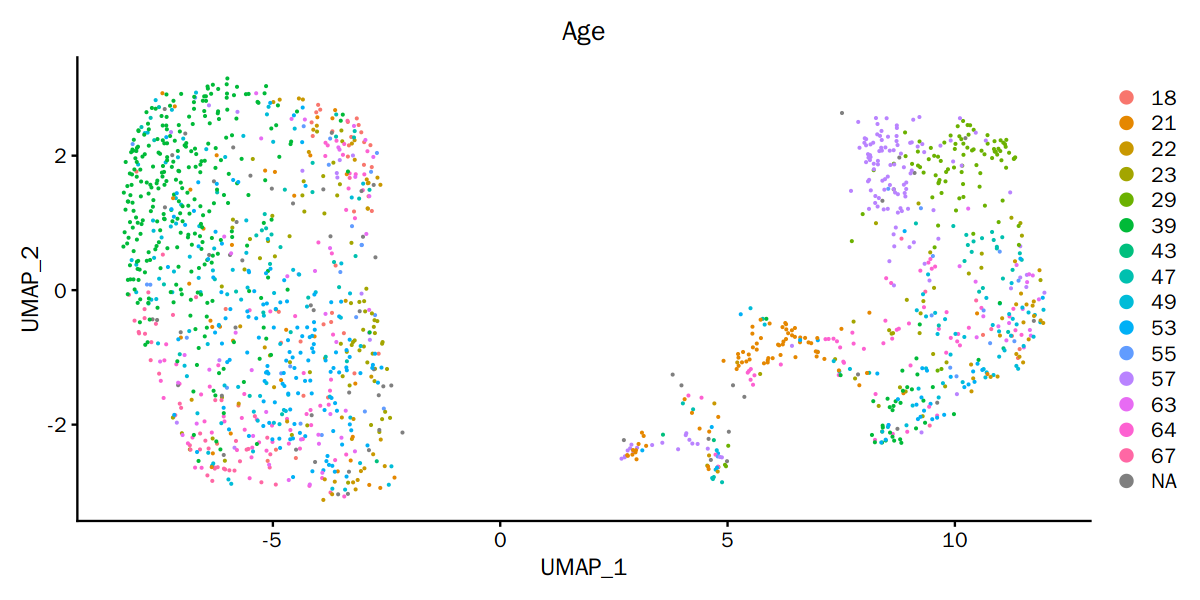

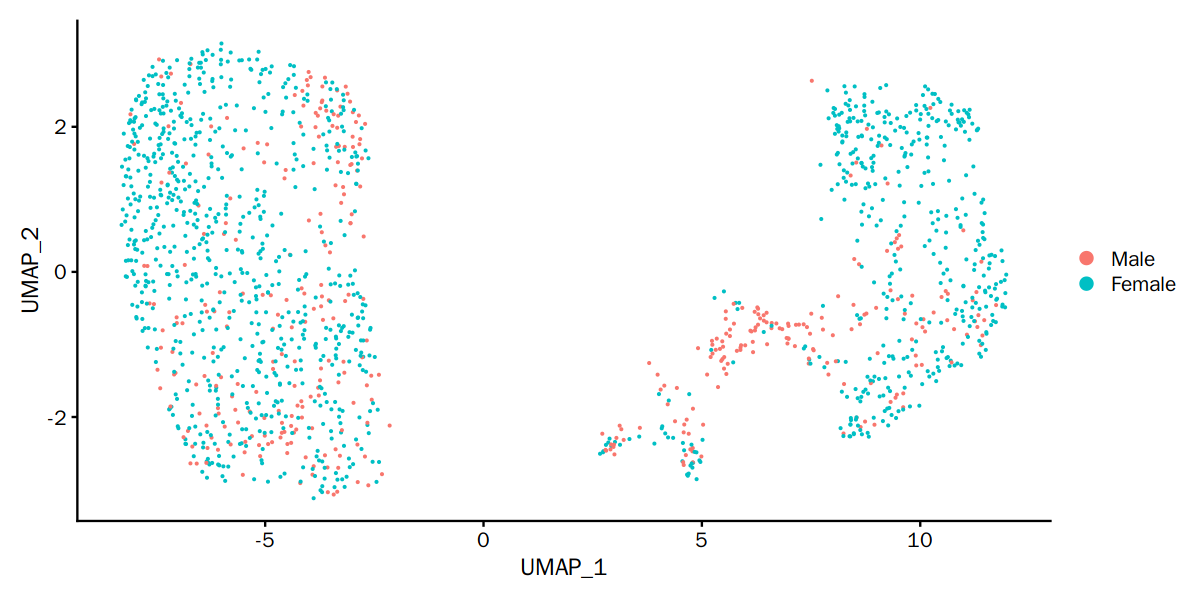

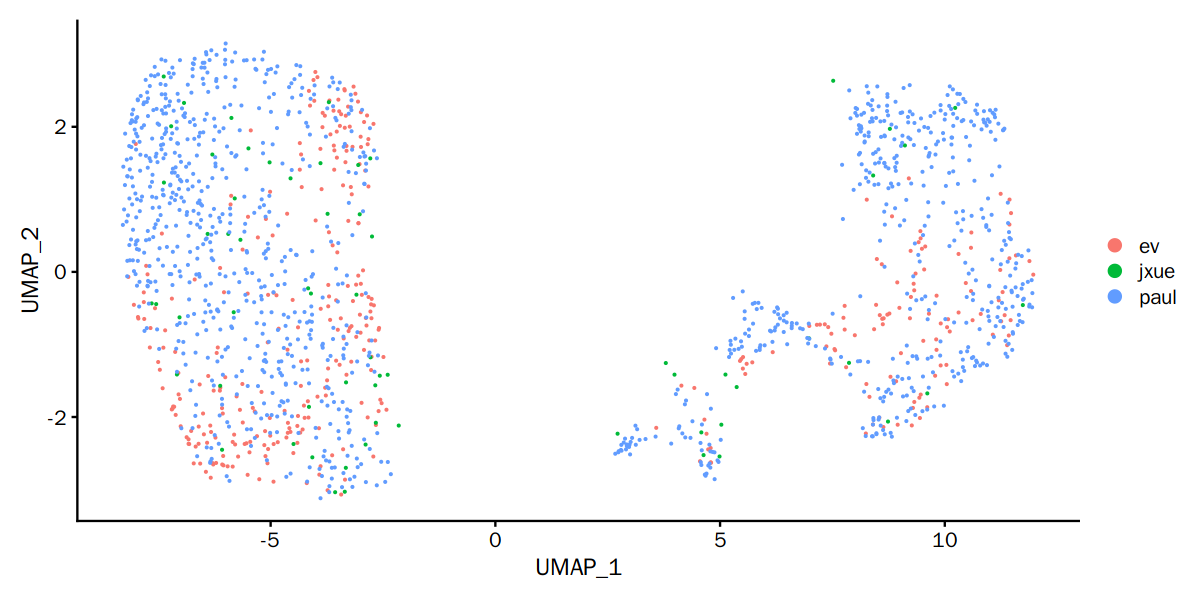

In [46]:
# --- Check CCA results
options(repr.plot.height = 5, repr.plot.width = 10)
# Sample
pdf(file="./figures/SampleID.pdf", width=8,height=5)
Idents(immune) <- "SamNum"
DimPlot(immune, reduction = "umap",label = FALSE, pt.size = 1, cols = viridis(25, option = "D"))
dev.off()

# cohort
pdf(file="./figures/Subject.pdf", width=6, height=5)
Idents(immune) <- "Cohort"
DimPlot(immune, reduction = "umap",label = FALSE, pt.size = 1, cols = viridis(3, option = "D"))
dev.off()

# # Age
# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/Age.pdf", width=15)
DimPlot(immune, reduction = "umap",label = FALSE, pt.size = 0.1, group.by="Age")
# dev.off()

# Gender
# pdf(file="/share/home/qlab/projects/qlab_yrs/project_ssc/result/Umap/SSC_Combine/Gender.pdf", width=15)
Idents(immune) <-"Gender"
DimPlot(immune, reduction = "umap",label = FALSE, pt.size = 0.1)
# dev.off()
Idents(immune) <-"Cohort"
DimPlot(immune, reduction = "umap",label = FALSE, pt.size = 0.1)

In [27]:
# --- FeaturePlot
options(repr.plot.height = 30, repr.plot.width = 30)
DefaultAssay(immune) <- "RNA"
pdf('./figures/B_Features.pdf', width = 24, height = 20)
FeaturePlot(immune, pt.size = 1.75,  features=c("JCHAIN","MS4A1", # 确定plasma 和 Bcell
                                       # B cell Anno
                                       "CD27","IGHD", #Mature Naive：-/+
                                       "IGHM", #GC dependent:CD27+; memory IGM+/IGM-
                                        'CCL18',#"CD38", #GC dependent
                                       # plasma Anno
                                       "PRDM1",# high: mature; low:immature
                                       "IGHG1","IGHA2", #和PRDM1 一起确定plasma的成熟情况与分型
                                       "RGS13","KRT8","MZB1","CD3D"))
dev.off()

png 
  2

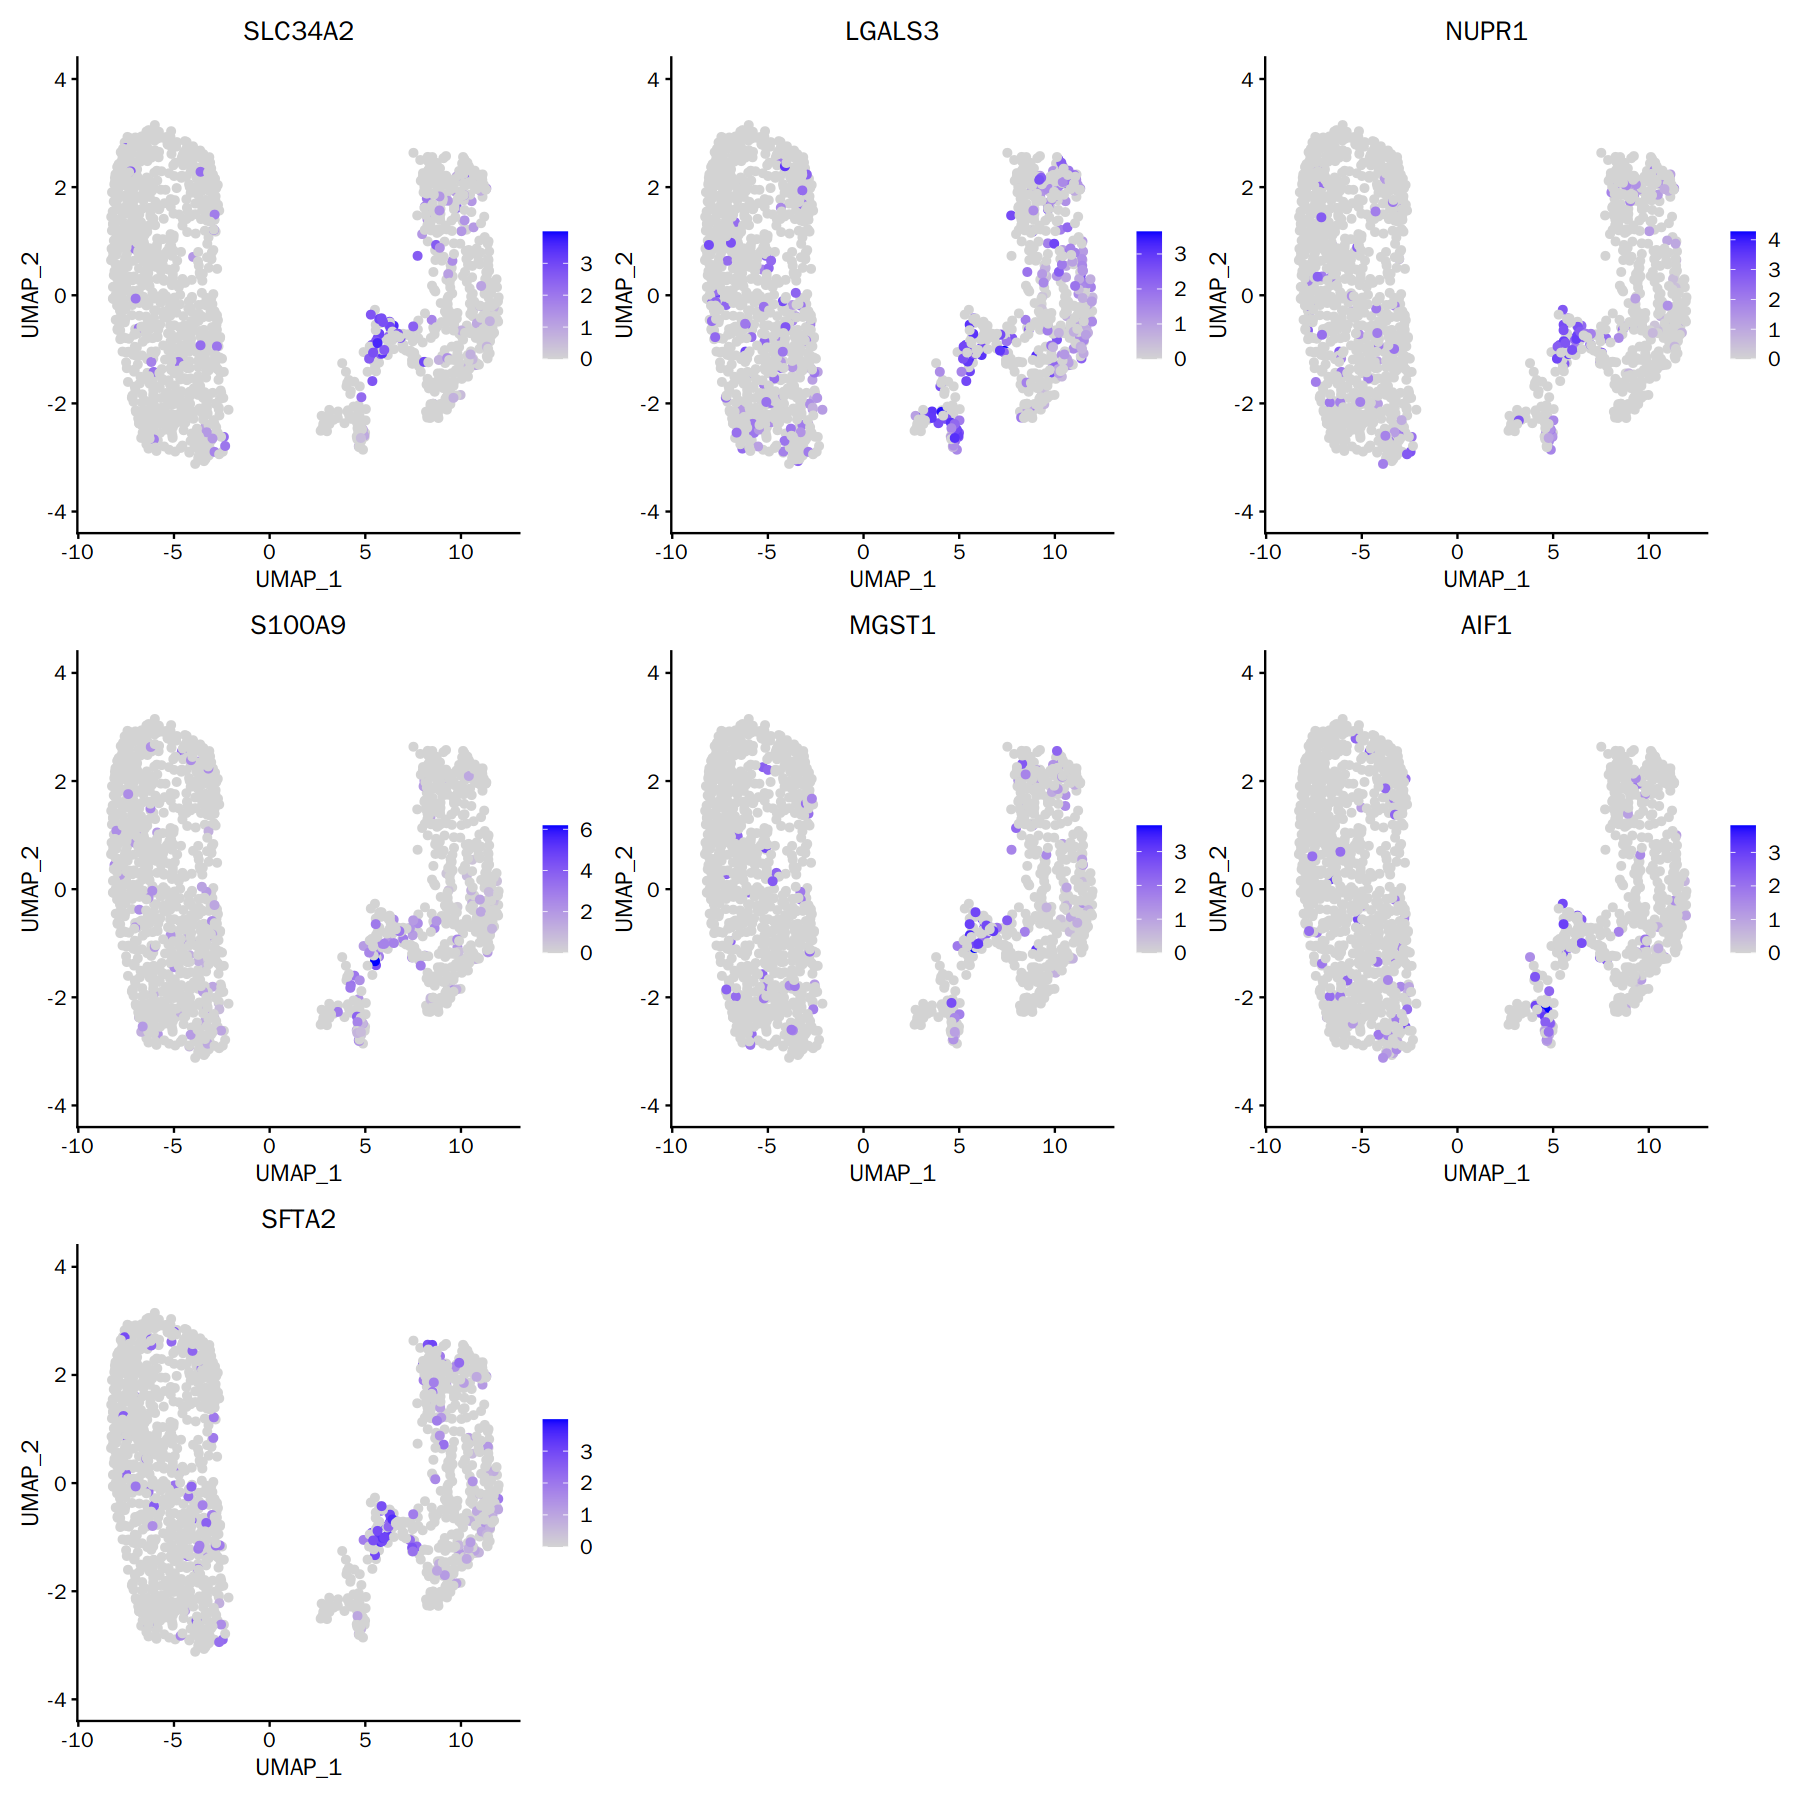

In [24]:
options(repr.plot.height = 15, repr.plot.width = 15)
FeaturePlot(immune, pt.size = 1.75,  features=c('SLC34A2', 'LGALS3', 'NUPR1', 'S100A9', 'MGST1', 'AIF1', 'SFTA2'))

In [48]:
options(repr.plot.height = 5, repr.plot.width = 7)
DefaultAssay(immune) <- 'RNA'
Idents(immune)<-"b_CellType"
# VlnPlot(immune, cols = viridis(2, option = "G"),
#         features = c("FLNA",'LPP'),
#         slot = "data",stack=TRUE, flip = T, adjust = 2)
pdf('./figures/VlnPlot.pdf', width = 5, height = 3)
VlnPlot(immune, features =c('IGHD', "IGHM", 'IGHG1', 'IGHA1'), stack = TRUE, assay = 'RNA', flip = T, adjust = 2, # CellFeatures:"IL1R1", "POSTN", "CXCL12", "FCN3", "EDNRB"
        cols =  viridis(4, option = "E"), group.by = 'b_CellType') + # split.by = 'Group',
  stat_summary(fun = mean, geom='point', size = 10, colour = "black", shape = 95, position =  position_dodge(width = 0.9)) 
  # stat_compare_means( label.y = 3, method = "t.test")
dev.off()

png 
  2

`summarise()` has grouped output by 'SamNum'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'SamNum', 'Group'. You can override using the
`.groups` argument.


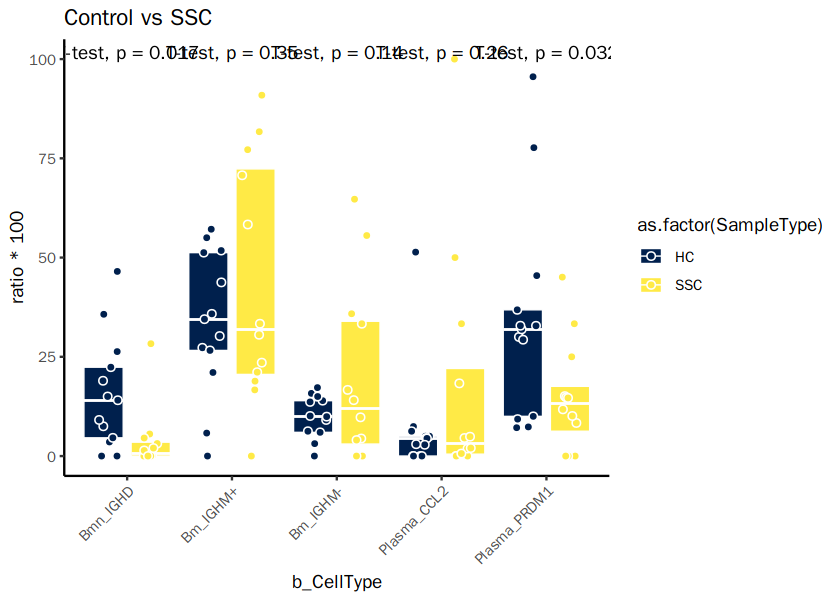

In [22]:
# --- Plot CellProp difference
classifier  <- "Group"
metadata.df  <- immune@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- immune@meta.data %>%
  dplyr::group_by(SamNum, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SamNum,!!sym(classifier), b_CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SamNum, SampleType), b_CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

ratio.df$b_CellType <- factor(ratio.df$b_CellType, ct.order)
# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")
fig.size(5,7)
ggplot(ratio.df,aes(x = b_CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.75) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+ 
  stat_compare_means(label.x = 10, method = "t.test") # aes(label = after_stat(p.signif)), 
ggsave('./figures/CellProp_with_B_denominators.pdf', width = 7, height = 5)

`summarise()` has grouped output by 'SamNum'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'SamNum', 'Group'. You can override using the
`.groups` argument.


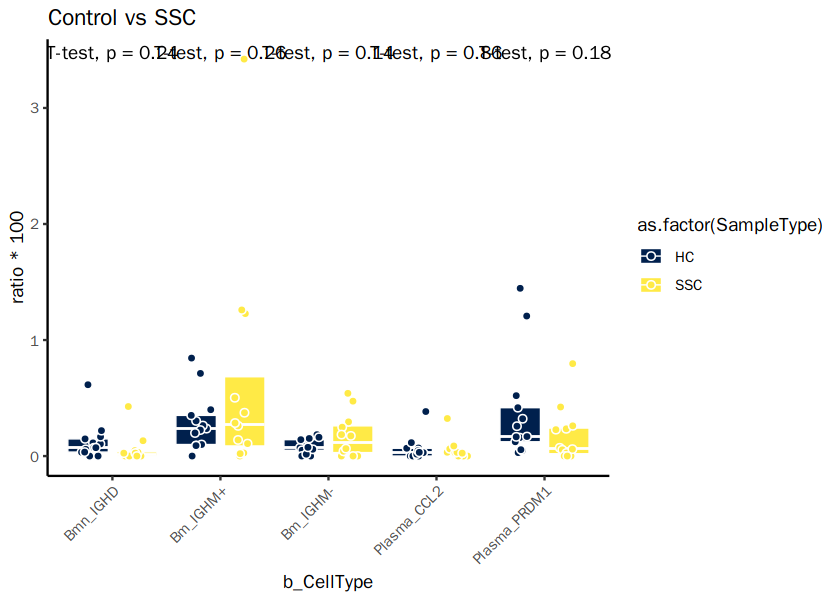

In [24]:
# --- Plot CellProp difference with sample cell number as denominators
ssc <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/object/all/sam_df_anno_SSC.rds")
classifier  <- "Group"
metadata.df  <- immune@meta.data %>%
  tibble::rownames_to_column(var = "Cell")
cell_num.df  <- ssc@meta.data %>%
  dplyr::group_by(SamNum, !!sym(classifier)) %>%
  dplyr::summarise(total = n()) %>%
  dplyr::ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  dplyr::select(ID,total)

ratio.df  <- metadata.df %>%
  dplyr::group_by(SamNum,!!sym(classifier), b_CellType) %>% #
  dplyr::summarise(sum = n()) %>%
  ungroup() %>%
  dplyr::rename(SampleType = 2) %>%
  tidyr::complete(nesting(SamNum, SampleType), b_CellType, fill = list(sum = 0)) %>% #
  dplyr::mutate(ID = paste0(SamNum,".",SampleType)) %>%
  left_join(cell_num.df, by = "ID") %>%
  rowwise() %>%
  dplyr::mutate(ratio = sum / total )

ratio.df$b_CellType <- factor(ratio.df$b_CellType, ct.order)
# colors.use  <- scales::viridis_pal()(3)[1:2]
colors.use  <- viridis(2, option = "E")
fig.size(5,7)
ggplot(ratio.df,aes(x = b_CellType, y = ratio * 100, fill = as.factor(SampleType))) + #
  geom_boxplot(outlier.shape = NA, position=position_dodge(width=0.9), size = 0.3, colour = "#FFFFFF") +
  geom_point(pch = 21, position = position_jitterdodge(), colour = "white", size = 1.75) +
  #   geom_jitter( size = 0.6 , position=position_dodge(width=0.9),aes(group=SampleType, alpha = 0.6)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("Control vs SSC") +
  scale_fill_manual(values = colors.use)+
  stat_compare_means(label.x = 10, method = "t.test") #aes(label = after_stat(p.signif)),
ggsave('./figures/CellProp_with_AllCells_denominators.pdf', width = 7, height = 5)

In [25]:
# # --- Plot Mrkers in each clusters
options(repr.plot.height = 6, repr.plot.width = 5)
# Idents(immune) <- 'b_CellType'
# # immune@meta.data$mo_CellType <- factor(immune@meta.data$b_CellType, levels = ct.order)
# markers <- FindAllMarkers(immune, assay = 'RNA', only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)


mrk.gene <- c("MS4A1", "JCHAIN",
              'CD27', "IGHD", 'CD79B',"CD79A", 'GPR183',
              'EBI3', 'FCRL4', 'DUSP4', 
              'LGALS3', 
              'CCL2', 'CCL5', # ‘terminal’ plasma
              'CCR10', 
              'XBP1',"PRDM1", # ‘active’ plasma cells
               # "IGHA1","IGHG2"
              
              'TXNDC5'
              # "HLA-DRA",'HLA-DPB1', 'HLA-DQA1', 
              # "CD38", "IGHM",
              # 'FTL', 'S100A8', 'C1QC', 'ANXA1',
    )
pdf('./figures/HM_mrkgenes.pdf', width = 5, height= 6)
averageHeatmap(object = immune, markerGene = mrk.gene, annoCol = TRUE, myanCol = viridis(5, option = "D"))
dev.off()

png 
  2

In [27]:
# --- HM：severarl pathway genes
options(repr.plot.height = 12, repr.plot.width = 8)
DefaultAssay(immune) <- 'RNA'
immune@meta.data$hm_group <- paste0(immune@meta.data$Group, '|', immune@meta.data$b_CellType)
Idents(immune) <- 'hm_group'
immune@meta.data$hm_group <- factor(immune@meta.data$hm_group,
                                              levels = c('HC|Bmn_IGHD', 'SSC|Bmn_IGHD',
                                                         'HC|Bm_IGHM+', 'SSC|Bm_IGHM+',
                                                         'HC|Bm_IGHM-', 'SSC|Bm_IGHM-', 
                                                         'HC|Plasma_CCL2', 'SSC|Plasma_CCL2', 
                                                         'HC|Plasma_PRDM1', 'SSC|Plasma_PRDM1'))

ifm.genes <- c('IL1B', 'SOCS3','TNF','IFNG', 'CXCL10','CXCL8', 'CXCL2',  'CCL2', 'CCL4L2', 'CCL5', 'CCL18', 'TGFB1')
    # c('IFNG', 'IL32','IL1B', 'CCL5', 'CCL18') # inflammatory
igh.genes <- c('IGHD', 'IGHM', 'IGHA1', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHGP', 'IGHG1', 'IGHG3')
fibro.genes <- c('IGFBP7', 'DCN', 'CCNH', 'SPARC', 'COL1A2', 'RGS5','CTHRC1', 'SPARC', 'THY1')

mrk.genes <- c(ifm.genes, igh.genes, fibro.genes) %>% unique()

sam.avg <- AverageExpression(immune, assays = 'RNA', group.by = 'hm_group')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.genes] %>% scale(scale = TRUE, center = TRUE)

info <- immune@meta.data[, c('hm_group', 'Group', 'b_CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'hm_group') 

ann_colors=list(b_CellType = c(Bmn_IGHD = '#FDE725FF', `Bm_IGHM+` = '#440154FF', `Bm_IGHM-` = '#2A788EFF',  Plasma_CCL2 = '#22A884FF', Plasma_PRDM1 = '#414487FF'),
                Group = c(SSC = "#B17AA1", HC = "#184995"))
ct.list <- c('HC|Bmn_IGHD', 'SSC|Bmn_IGHD',
             'HC|Bm_IGHM+', 'SSC|Bm_IGHM+',
             'HC|Bm_IGHM-', 'SSC|Bm_IGHM-', 
             'HC|Plasma_CCL2', 'SSC|Plasma_CCL2', 
             'HC|Plasma_PRDM1', 'SSC|Plasma_PRDM1')
pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 10, height = 10)
hm <- pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             annotation_col = info[,c('b_CellType','Group')],
             annotation_colors = ann_colors,
             gaps_row = c(length(ifm.genes), 
                         length(c(ifm.genes))+ length(igh.genes)),
                        # length(c(cyto.genes, inhibit.genes, ifm.genes))+length(death.genes)),
            gaps_col = c(2,4,6,8,10)
            ) 
print(hm)
dev.off()

Warning message:
“Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix.”


png 
  2

In [3]:
# --- plot DEGs in each b_CellType
immune.f0 <- subset(immune, Cohort %in% c('ev', 'paul')) 
data <- NULL
for(ct in unique(immune.f0@meta.data$b_CellType)){
    print(ct)
    immune.f <- subset(immune.f0, b_CellType == ct)
    DefaultAssay(immune.f) <- 'RNA'
    cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
    print(length(cell.ssc))
    cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
    print(length(cell.hc))
    diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
    diff$b_CellType <- ct
    data <- rbind(data, diff)
}
data %>% mutate(Compare = 'SSc_VS_HC') %>% write.csv('Figure6.mo.csv', row.names = F)
# library(ggsci)
# diff.all <- data
# diff.all$sig <- 'no'
# diff.all$sig[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC > 0.5)] <- 'up'
# diff.all$sig[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC < -0.5)] <- 'down'
# diff.all$label <- ', '
# diff.all$label[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC > 1)] <- diff.all$gene[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC > 1)]
# diff.all$label[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC < -1)] <- diff.all$gene[which(diff.all$p_val < 0.05 & diff.all$avg_log2FC < -1)]
# # diff.all$label[which(diff.all$sig %in% c('down', 'up'))] <- diff.all$gene[which(diff.all$sig %in% c('down', 'up'))] 
# diff.all$b_CellType <- factor(diff.all$b_CellType,
#                               levels = ct.order)

# dfcol<- data.frame(x = ct.order, y = 0, label = ct.order)
# dfcol$label <- factor(dfcol$label, levels = ct.order)
# mycol <- pal_d3("category20")(5)
# # --- Count DEGs numbers
# deg.num.df <- diff.all %>% dplyr::filter(sig %in% c('up', 'down')) %>% 
#                 group_by(b_CellType, sig) %>% summarise(num = n()) %>%
#                 as.data.frame() %>% mutate(num_new = ifelse(sig == 'up', num, -num))
# # # --- set specifically displayed genes
# # hypoxia.rec.genesets <- c('ARNT', 'CA9', 'CREBBP', 'EP300', 'EPAS1', 'EPO', 'HIF1A', 'ELOC', 'ELOB', 'VEGFA', 
# #                           'VHL','CUL2', 'RBX1', 'CITED2', 'HIGD1A', 'HIF1AN', 'HIF3A', 'EGLN2', 'EGLN3')
# # diff.all$label_hypo <-', '
# # diff.all$label_hypo[which(diff.all$gene %in% hypoxia.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% hypoxia.rec.genesets)]
# # diff.all$label_hypo[which(diff.all$sig == 'no')] <- ', '

# # O2_CO2.rec.genesets <- c('AQP1', 'CA1', 'CA2', 'CA4', 'HBA2', 'HBB', 'RHAG', 'SLC4A1')
# # diff.all$label_o2 <-', '
# # diff.all$label_o2[which(diff.all$gene %in% O2_CO2.rec.genesets)] <- diff.all$gene[which(diff.all$gene %in% O2_CO2.rec.genesets)]
# # diff.all$label_o2[which(diff.all$sig == 'no')] <- ', '

# options(repr.plot.height = 6, repr.plot.width = 10)
# diff.all$sig = factor(diff.all$sig, levels = c('down', 'no', 'up'))
# ggplot()+
#     geom_jitter(data = diff.all %>% dplyr::filter(sig == "no"), 
#                 aes(x = b_CellType, y = avg_log2FC, color = sig), size = 1, width = 0.4, alpha = 0.5) +
#     geom_jitter(data = diff.all %>% dplyr::filter(sig %in% c('down', 'up')),
#                 aes(x = b_CellType, y = avg_log2FC, color = sig), size = 1.5, width = 0.4, alpha = 0.5) +  
#     scale_color_manual(values = c("grey","#184995","#B17AA1")) +
#     # --- plot label
# ggrepel::geom_text_repel(data = diff.all, 
#                          ggplot2::aes(x = b_CellType, y = avg_log2FC, label = label, color = sig), max.overlaps = 50) +
#     # geom_text_repel(data = diff.all, #%>% dplyr::filter(label_hypo == ', ' & label_o2 == ', '), 
#     #                 aes(x = b_CellType, y = avg_log2FC, label=label, color = sig), 
#     #                 size = 3, force = 0.5, max.overlaps = 15) +
#     geom_tile(data = dfcol, aes(x=x, y=y), height=0.5, color = "black", fill = mycol, alpha = 0.8, show.legend = F) +
#     geom_text(data = dfcol, aes(x=x, y=y,label=x), size = 5 , color ="black") +
#     labs(x="b_CellType", y="avg_log2FC") +
#     theme_bw() +  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) +
#     ggtitle('SSC VS HC in each b_CellType') 
# ggsave('./figures/DEGs_in_bCellType.pdf', width = 7, heigh = 5)

# ggplot() + 
# geom_bar(data= deg.num.df, aes(x = b_CellType, y = num,  fill = sig), stat="summary", fun='mean', position = position_dodge(), alpha = 0.5) +
# scale_fill_manual(values = c("#184995", "#B17AA1")) +
# theme_classic()
# ggsave('./figures/DEGsNumber_in_bCellType.pdf', width = 7, heigh = 5)

[1] "Bm_IGHM+"
[1] 111
[1] 140
[1] "Bm_IGHM-"
[1] 355
[1] 179
[1] "Bmn_IGHD"
[1] 72
[1] 103
[1] "Plasma_PRDM1"
[1] 103
[1] 341
[1] "Plasma_CCL2"
[1] 24
[1] 85


In [192]:
# Enriched Pathway in SSC of each b_CellType
diff.all <- data
# pdf('./figures/upDEGs_Reactome.pdf', width =12, height =6)
for(i in seq_along(ct.order)){
    c1.gene = diff.all %>% dplyr::filter(p_val < 0.05 & avg_log2FC > 0 & b_CellType == ct.order[i]) %>% 
            arrange(-avg_log2FC) %>% pull(gene) %>% .[1:200]
    geneset  <- biosets[['REACTOME']]
    if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
    hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000)
    hyp_obj$data$label <- str_replace(hyp_obj$data$label, 'REACTOME_', ', ')
    
    pdf(paste0('./figures/ct_reactome/', ct.order[i], '_plot.pdf'), width = 4, height = 5)
    p.plot <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,] %>%
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log10(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.order[i], perl = TRUE),': enriched Reactome pathways')) + 
                theme(axis.text.y = element_blank())
    print(p.plot)
    dev.off()
        
    pdf(paste0('./figures/ct_reactome/', ct.order[i], '_yaxis.pdf'), width = 8, height = 5)        
    p.y <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,]  %>% 
            mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
            ggplot(aes(x = -log10(pval), y = pathway)) +
                geom_point(aes(size = GeneNum, color = -log(fdr))) +
                scale_color_gradient(low="#136885",high = "#FAB35B") +
                theme_bw() + labs(color = "-Log(FDR)") +
                ggtitle(paste0(gsub("(\\D)(\\D+)", "\\U\\1\\L\\2", ct.order[i], perl = TRUE),': enriched Reactome pathways')) 
    print(p.y)
    dev.off()
}
# dev.off()

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `pathway = fct_reorder(label, -fdr)`.
Caused by warning:
! `fct_reorder()` removing 8 missing values.
ℹ Use `.na_rm = TRUE` to silence this message.
ℹ Use `.na_rm = FALSE` to preserve NAs.”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `pathway = fct_reorder(label, -fdr)`.
Caused by warning:
! `fct_reorder()` removing 8 missing values.
ℹ Use `.na_rm = TRUE` to silence this message.
ℹ Use `.na_rm = FALSE` to preserve NAs.”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


In [35]:
# --- Plot Enriched path ways in B cells
immune.f <- subset(immune, Cohort %in% c('ev', 'paul')) %>% subset(b_CellType %in% c('Bmn_IGHD', 'Bm_IGHM+', 'Bm_IGHM-'))
DefaultAssay(immune.f) <- 'RNA'
cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
print(length(cell.ssc))
cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
print(length(cell.hc))
diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
diff$b_CellType <- ct
c1.gene = diff %>% dplyr::filter(p_val < 0.05 & avg_log2FC > 0) %>% 
            arrange(-avg_log2FC) %>% pull(gene) 
geneset  <- biosets[['REACTOME']]
if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000)
hyp_obj$data$label <- str_replace(hyp_obj$data$label, 'REACTOME_', ', ')

pdf(paste0('./figures/ct_reactome/Bcell_plot.pdf'), width = 4, height = 5)
p.plot <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,] %>%
        mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
        ggplot(aes(x = -log10(pval), y = pathway)) +
            geom_point(aes(size = GeneNum, color = -log(fdr))) +
            scale_color_gradient(low="#136885",high = "#FAB35B") +
            theme_bw() + labs(color = "-Log(FDR)") +
            theme(axis.text.y = element_blank())+
            ggtitle(paste0('Bcell: enriched Reactome pathways')) 
print(p.plot)
dev.off()
    
pdf(paste0('./figures/ct_reactome/Bcell_yaxis.pdf'), width = 8, height = 5)        
p.y <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,]  %>% 
        mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
        ggplot(aes(x = -log10(pval), y = pathway)) +
            geom_point(aes(size = GeneNum, color = -log(fdr))) +
            scale_color_gradient(low="#136885",high = "#FAB35B") +
            theme_bw() + labs(color = "-Log(FDR)") +
            ggtitle(paste0('Bcell: enriched Reactome pathways')) 
print(p.y)
dev.off()

[1] 538
[1] 422


png 
  2

png 
  2

In [203]:
# --- Plot Enriched path ways in Plasma
immune.f <- subset(immune, Cohort %in% c('ev', 'paul')) %>% subset(b_CellType %in% c('Plasma_CCL2', 'Plasma_PRDM1'))
DefaultAssay(immune.f) <- 'RNA'
cell.ssc <- immune.f@meta.data %>% subset(Group == 'SSC') %>% rownames()
print(length(cell.ssc))
cell.hc <- immune.f@meta.data %>% subset(Group == 'HC') %>% rownames()
print(length(cell.hc))
diff <- FindMarkers(immune.f, min.pct = 0.01, logfc.threshold = 0.2, ident.1 = cell.ssc, ident.2 = cell.hc) %>% rownames_to_column(var = "gene")
diff$b_CellType <- ct
c1.gene = diff %>% dplyr::filter(p_val < 0.05 & avg_log2FC > 0) %>% 
            arrange(-avg_log2FC) %>% pull(gene) 
geneset  <- biosets[['REACTOME']]
if(length(geneset$genesets[duplicated(geneset$genesets)]) >0){geneset$genesets <- geneset$genesets[!duplicated(geneset$genesets)]}
hyp_obj <- hypeR(c1.gene, geneset,test="hypergeometric", background=30000)
hyp_obj$data$label <- str_replace(hyp_obj$data$label, 'REACTOME_', ', ')

pdf(paste0('./figures/ct_reactome/Plasma_plot.pdf'), width = 4, height = 5)
p.plot <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,] %>%
        mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
        ggplot(aes(x = -log10(pval), y = pathway)) +
            geom_point(aes(size = GeneNum, color = -log(fdr))) +
            scale_color_gradient(low="#136885",high = "#FAB35B") +
            theme_bw() + labs(color = "-Log(FDR)") +
            theme(axis.text.y = element_blank())+
            ggtitle(paste0('Plasma: enriched Reactome pathways')) 
print(p.plot)
dev.off()
    
pdf(paste0('./figures/ct_reactome/Plasma_yaxis.pdf'), width = 8, height = 5)        
p.y <- hyp_obj$data %>% dplyr::filter(fdr < 0.01 & pval < 0.05 & overlap >=3 ) %>% arrange(fdr) %>% .[1:10,]  %>% 
        mutate(pathway = fct_reorder(label, -fdr), GeneNum = overlap) %>%
        ggplot(aes(x = -log10(pval), y = pathway)) +
            geom_point(aes(size = GeneNum, color = -log(fdr))) +
            scale_color_gradient(low="#136885",high = "#FAB35B") +
            theme_bw() + labs(color = "-Log(FDR)") +
            ggtitle(paste0('Plasma: enriched Reactome pathways')) 
print(p.y)
dev.off()

[1] 127
[1] 426


png 
  2

png 
  2

In [48]:
# --- Upset plots shows the shared BCR clonetype in three sites
pbmc.immune <- readRDS("/share/home/qlab/projects/qlab_yrs/project_ssc/data/pbmc/object/anno_SSC_filter.rds") %>% subset(Subject == 'jxue') %>%
                subset(CellType == 'B_cell')
pbmc.meta <- pbmc.immune@meta.data
pbmc.meta.cell <- pbmc.meta %>% mutate(Cohort = Subject) %>% .[,c('Cohort', 'CellType')] %>% rownames_to_column(var = 'barcode') %>% mutate(Site = 'PBMC')
lung.meta.cell <- immune@meta.data %>% dplyr::filter(Cohort == 'jxue') %>%
                    mutate(CellType = b_CellType) %>% .[,c('Cohort', 'Site', 'CellType')] %>% rownames_to_column(var = 'barcode')
meta.cell <- rbind(pbmc.meta.cell, lung.meta.cell)
# --- Added BCR cell_clone results
bcr.df <- readRDS('/share/home/qlab/projects/qlab_yrs/project_ssc/matrix/BCR/cell_bcr_new.rds') %>% dplyr::rename(barcode = cell) %>%
            left_join(meta.cell, by ='barcode')
bcr.clone.freq <- bcr.df %>% na.omit() %>% group_by(code) %>% summarise(CloneFreq = n()) %>% as.data.frame() %>% dplyr::filter(code != 'NA')
bcr.df <- bcr.df %>% dplyr::filter(code != 'NA') %>% na.omit() %>% # --- 去除 NA
            left_join(bcr.clone.freq, by = 'code')

library(UpSetR)
upset_data <- bcr.df %>% dplyr::group_by(Site, code) %>% dplyr::summarise(Num = n()) %>% as.data.frame() %>% 
                pivot_wider(names_from = Site, values_from = Num, values_fill = 0) %>% as.data.frame() %>% column_to_rownames(var = 'code') %>% 
                mutate(LOW = ifelse(lung_LOW > 0, 1, 0), PBMC = ifelse(PBMC > 0, 1, 0), UP = ifelse(lung_UP > 0, 1, 0)) 
head(upset_data)
pdf('./figures/BCR_CloneType_UpSetR.pdf', width = 5, height = 5)
upset(
    upset_data,
  sets = c("LOW", "PBMC", "UP"), # Specify the sets
  nintersects = 10,              # Show top 10 intersections
  order.by = "freq",             # Order intersections by frequency
  decreasing = TRUE              # Descending order
)
dev.off()

sites3.ct <- upset_data %>% dplyr::filter(LOW == 1 & PBMC == 1 & UP == 1) %>% rownames()
sites3.ct # IGH:CATGHGGSFGYW;IGK:CQQYNTYPFTF
# seq.info <- readRDS('/share/home/qlab/projects/qlab_yrs/project_ssc/matrix/BCR/bcr_new_codes.rds')
# seq.info %>% dplyr::filter(code %in% c('IGH_2', 'IGK_2'))

bcr.df %>% 
group_by(code) %>% summarise(nn = n()) %>% 
dplyr::filter(nn > 1)

`summarise()` has grouped output by 'Site'. You can override using the `.groups` argument.


,PBMC,lung_LOW,lung_UP,LOW,UP
,<dbl>,<int>,<int>,<dbl>,<dbl>
IGH_100;IGL_56,1,0,0,0,0
IGH_102;IGK_86,1,0,0,0,0
IGH_103;IGK_49;IGK_55,1,0,0,0,0
IGH_104;IGK_87,1,0,0,0,0
IGH_105;IGK_94,1,0,0,0,0
IGH_106;IGL_57,1,0,0,0,0


png 
  2

[1] "IGH_2;IGK_2"

code,nn
<chr>,<int>
IGH_163;IGL_88,2
IGH_17;IGK_15,3
IGH_2;IGK_2,46
IGH_2;IGK_2;IGL_1,6
IGH_332;IGK_273,2
IGH_39;IGK_33;IGK_41,2
IGH_52;IGL_15,2
IGH_6;IGK_5,4
IGK_2,2


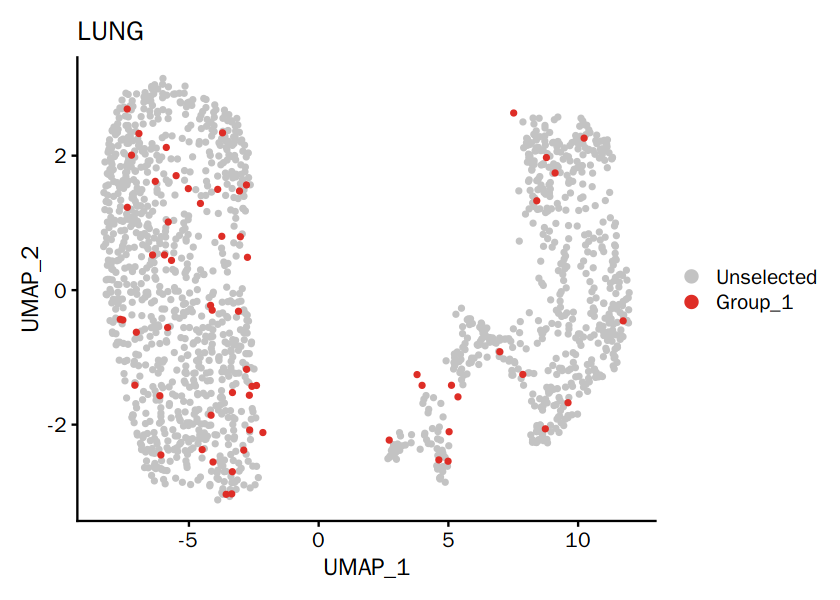

In [93]:
cell.high <- immune@meta.data %>% dplyr::filter(code != 'NA') %>% rownames()
# pdf('./figures/PBMC_Overlapped_TCR.pdf', width = 6, height = 5)
Idents(immune) <- 'b_CellType'
DimPlot(immune, reduction = "umap", label=FALSE, label.size=5, cells.highlight = cell.high,
        label.color = "black", label.box = TRUE, pt.size = 1, raster = FALSE, repel = TRUE) +
ggtitle('LUNG')

In [21]:
# # --- Add annotations for a specific clustering
# immune@meta.data$b_CellType <- as.character(immune@meta.data$b_CellType)
# ct.res <- data.frame(b_CellType = immune@meta.data$b_CellType %>% as.character() %>% unique(),
#                      celltype.res.0.1 = 0:(length(immune@meta.data$b_CellType %>% as.character() %>% unique()) - 1))
# meta <- immune@meta.data
# immune@meta.data <- meta %>% 
#                     rownames_to_column(var = 'barcode') %>%
#                     left_join(ct.res, by = 'b_CellType') %>%
#                     column_to_rownames(var = 'barcode')

# immune@meta.data$Site[is.na(immune@meta.data$Site)] <- 'lung'
# immune@meta.data$Site[which(immune@meta.data$Site == 'UP')] <- 'lung_UP'
# immune@meta.data$Site[which(immune@meta.data$Site == 'LOW')] <- 'lung_LOW'
# immune@meta.data$Age[which(immune@meta.data$SamNum %in% c('SScJ1', 'SScJ2'))] <- 54

# DefaultAssay(immune) <- 'RNA'
# Idents(immune) <- 'celltype.res.0.1'
# markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
# saveRDS(markers, file = paste0('SnnGenes/ct_res.0.1.rds.gz'), compress = "gzip")
# saveRDS(immune, './B_lung.rds')

In [24]:
immune@meta.data[,c('SamNum', 'Group', 'Site', 'Age', 'Gender', 'Cohort')] %>% distinct()

,SamNum,Group,Site,Age,Gender,Cohort
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
CONTROL 1_ACATGGTCAGGTGGAT-1,CONTROL 1,HC,lung,55,Male,ev
CONTROL 2_AAGACCTAGACTACAA-1,CONTROL 2,HC,lung,57,Female,ev
CONTROL 3_AAAGATGCACCTGGTG-1,CONTROL 3,HC,lung,18,Male,ev
CONTROL 5_AAAGTAGTCATCTGCC-1,CONTROL 5,HC,lung_LOW,23,Female,ev
CONTROL 4_AACCATGGTAAAGGAG-1,CONTROL 4,HC,lung_UP,23,Female,ev
SSC 2_ACAGCCGAGGTACTCT-1,SSC 2,SSC,lung_UP,67,Female,ev
SSC 1_AAAGTAGCACAGACTT-1,SSC 1,SSC,lung_LOW,67,Female,ev
SSC 4_GCTCTGTAGAAACCTA-1,SSC 4,SSC,lung_UP,43,Male,ev
SSC 3_ATGCGATTCAAAGACA-1,SSC 3,SSC,lung_LOW,43,Male,ev


In [26]:
# # --- Create Scoupe_Loom file
# library(SCopeLoomR)
# library(hdf5r)

# # --- 01 Create a loom file
# build_loom(file.name = "lung_immune.loom",
#         dgem = immune@assays$RNA@counts,
#         title = "B_lymphocyte",
#         default.embedding = immune@reductions$umap@cell.embeddings,
#         default.embedding.name = "umap.rna")

# loom <- open_loom("lung_immune.loom", mode = "r+")
# # --- 02 Add hierachy
# add_hierarchy(
#   loom = loom,
#   hierarchy = create_hierarchy(
#     level.1.name = "SSc-ILD",
#     level.2.name = "Lung-B"
#   )
# )
# # --- 03 Add embedding(s)
# add_embedding(loom = loom, 
#               embedding = immune@reductions$pca@cell.embeddings,
#               name = "pca")

# # --- 04 Add MetaDate
# names(loom[["col_attrs"]])
# add_col_attr(loom = loom, key = "Sample", value = immune@meta.data$SamNum, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Group", value = immune@meta.data$Group, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Site", value = immune@meta.data$Site, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Age", value = immune@meta.data$Age, as.metric = TRUE)
# add_col_attr(loom = loom, key = "Gender", value = immune@meta.data$Gender, as.annotation = TRUE)
# add_col_attr(loom = loom, key = "Cohort", value = immune@meta.data$Cohort, as.annotation = TRUE)

# immune@meta.data$b_CellType <- as.character(immune@meta.data$b_CellType)
# add_col_attr(loom = loom, key = "CellType", value = immune@meta.data$b_CellType, as.annotation = TRUE)

# names(loom[["col_attrs"]])

# # --- 05 Add Seurat clusters and markers
# add_seurat_clustering(loom = loom,
#         seurat = immune,
#         seurat.assay = "RNA",
#         seurat.clustering.prefix = "celltype.res.",
#         seurat.markers.file.path.list = 
#           list(celltype.res.0.1 = './SnnGenes/ct_res.0.1.rds.gz'),
#         seurat.marker.metric.accessors = c("avg_log2FC", "p_val"),
#         seurat.marker.metric.names = c("Avg. log2FC", "P-value"),
#         seurat.marker.metric.description = c("Average log fold change", "Adjusted p-value (BF)")
# )

# # --- 06 save loom file
# close_loom(loom)

In [4]:
immune <- readRDS('B_pbmc.rds') %>% subset(CellType %in% c('B_naive', 'B_memory', 'IgA_immature'))

In [6]:
DefaultAssay(immune) <- "RNA"
Idents(immune) <- "CellType"
markers <- FindAllMarkers(immune, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(markers, file="PBMC_SubCellType_Top_Genes.csv")

Calculating cluster B_naive

Calculating cluster B_memory

Calculating cluster IgA_immature



Warning message:
“Column annotation has different order from matrix columns. Adjust the
column annotation based on column names of the matrix.”


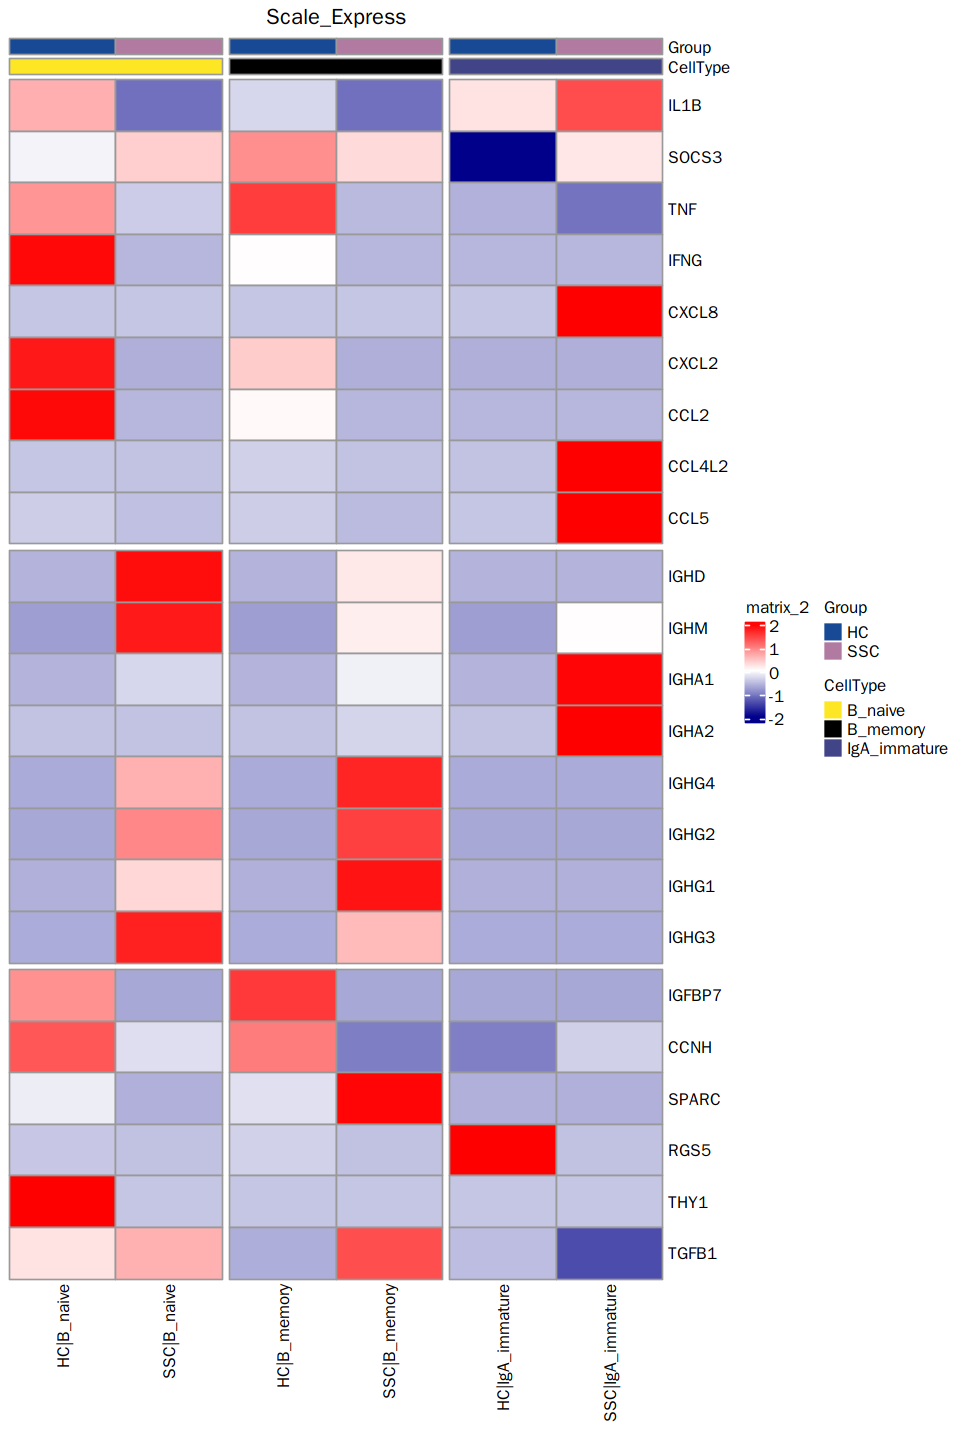

In [52]:
# --- HM：severarl pathway genes
options(repr.plot.height = 12, repr.plot.width = 8)
DefaultAssay(immune) <- 'RNA'
immune@meta.data$hm_group <- paste0(immune@meta.data$Group, '|', immune@meta.data$CellType)
Idents(immune) <- 'hm_group'
immune@meta.data$hm_group <- factor(immune@meta.data$hm_group,
                                              levels = c('HC|B_naive', 'SSC|B_naive',
                                                         'HC|B_memory', 'SSC|B_memory',
                                                         'HC|IgA_immature', 'SSC|IgA_immature'))

ifm.genes <- c('IL1B', 'SOCS3','TNF','IFNG', 'CXCL8', 'CXCL2',  'CCL2', 'CCL4L2', 'CCL5')
    # c('IFNG', 'IL32','IL1B', 'CCL5', 'CCL18') # inflammatory
igh.genes <- c('IGHD', 'IGHM', 'IGHA1', 'IGHA2', 'IGHG4', 'IGHG2', 'IGHG1', 'IGHG3')
fibro.genes <- c('IGFBP7', 'CCNH', 'SPARC','RGS5', 'SPARC', 'THY1' , 'TGFB1')
mrk.genes <- c(ifm.genes, igh.genes, fibro.genes) %>% unique()

sam.avg <- AverageExpression(immune, assays = 'RNA', group.by = 'hm_group')
hm.df <- sam.avg$RNA %>% t() %>% as.data.frame() %>% .[, mrk.genes] %>% scale(scale = TRUE, center = TRUE)

info <- immune@meta.data[, c('hm_group', 'Group', 'CellType')] %>% unique() %>% {rownames(.) <- NULL; .} %>% column_to_rownames(var = 'hm_group') 

ann_colors=list(CellType = c(B_naive = '#FDE725FF', B_memory = 'black', IgA_immature = '#414487FF'),
                Group = c(SSC = "#B17AA1", HC = "#184995"))
ct.list <- c('HC|B_naive', 'SSC|B_naive',
             'HC|B_memory', 'SSC|B_memory',
             'HC|IgA_immature', 'SSC|IgA_immature')
# # pdf('./figures/HM_GeneExp_in_Groups.pdf', width = 10, height = 10)
hm <- pheatmap(hm.df[ct.list,] %>% t(), cluster_row = FALSE, cluster_col = FALSE, 
            color = c(colorRampPalette(colors = c("darkblue","white"))(50),colorRampPalette(colors = c("white", "red"))(50)), 
            main = ("Scale_Express"),
             annotation_col = info[,c('CellType','Group')],
             annotation_colors = ann_colors,
             gaps_row = c(length(ifm.genes), 
                         length(c(ifm.genes))+ length(igh.genes)),
                        # length(c(cyto.genes, inhibit.genes, ifm.genes))+length(death.genes)),
            gaps_col = c(2,4)
            ) 
print(hm)
# # dev.off()

In [2]:
immune <- readRDS('B_pbmc.rds')

In [5]:
immune@meta.data$CellType %>% unique()

[1] B_naive      B_memory     IgA_immature dbt          LQ          
Levels: B_naive B_memory LQ dbt IgA_immature